<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo 13** | Regressão II
Caderno de **exercício 02**<br>

# Regressão múltipla

Discente: Samuel Saturno


#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

Importando as bibliotecas

In [ ]:
import pandas as pd
import seaborn as sns
from seaborn import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import graphviz

from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importando o dataframe
df = pd.read_csv('/content/drive/MyDrive/previsao_de_renda.csv')

In [ ]:
# Exibindo as informações das colunas do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

Tratamento dos dados do dataframe

In [ ]:
# Usando a função drop para deletar as colunas irrelevante do dataframe
df = df.dropna()
df.drop(columns=['Unnamed: 0','data_ref','id_cliente'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12427 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   12427 non-null  object 
 1   posse_de_veiculo       12427 non-null  bool   
 2   posse_de_imovel        12427 non-null  bool   
 3   qtd_filhos             12427 non-null  int64  
 4   tipo_renda             12427 non-null  object 
 5   educacao               12427 non-null  object 
 6   estado_civil           12427 non-null  object 
 7   tipo_residencia        12427 non-null  object 
 8   idade                  12427 non-null  int64  
 9   tempo_emprego          12427 non-null  float64
 10  qt_pessoas_residencia  12427 non-null  float64
 11  renda                  12427 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 1.1+ MB


<ipython-input-5-7583b8632ba8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Unnamed: 0','data_ref','id_cliente'], inplace=True)


1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

### 1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).

In [ ]:
# Defina suas variáveis independentes (X) e variável dependente (y)
X = df[['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
        'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia',
        'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']]
y = df['renda']

# Separe os dados em conjunto de treinamento e teste (75% para treinamento, 25% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Criando um modelo de design matrix usando Patsy.
df_1 = patsy.dmatrices('''np.log(renda) ~ C(sexo)
                    + C(posse_de_veiculo)
                    + C(posse_de_imovel)
                    + qtd_filhos
                    + C(tipo_renda)
                    + C(educacao, Treatment(2))
                    + C(estado_civil)
                    + C(tipo_residencia, Treatment(1))
                    + idade
                    + tempo_emprego
                    + qt_pessoas_residencia
                    + 1''', X_test)

###  2. Rode uma regularização ridge com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o  R2  na base de testes. Qual o melhor modelo?

In [ ]:
# Cálculo de regressão do modelo aplicado o "elastic_net" com alpha = 0
modelo = smf.ols(df_1, data = X_test).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0)

# Exibindo o sumário do modelo
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     75.81
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          1.78e-288
Time:                        01:53:29   Log-Likelihood:                -3369.0
No. Observations:                3107   AIC:                             6788.
Df Residuals:                    3083   BIC:                             6939.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.7632      1.022      7.593      0.000       5.759       9.768
C(sexo)[T.M]                                          0.7800      0.029     26.491      0.000       0.722       0.838
C(posse_de_veiculo)[T.True]                           0.0940      0.029      3.279      0.001       0.038       0.150
C(posse_de_imovel)[T.True]                            0.0542      0.028      1.954      0.051      -0.000       0.109
C(tipo_renda)[T.Empresário]                           0.1231      0.029      4.189      0.000       0.065       0.181
C(tipo_renda)[T.Pensionista]                         -0.2766      0.510     -0.543      0.587      -1.276       0.722
C(tipo_renda)[T.Servidor público]                     0.0457      0.045      1.018      0.309      -0.042       0.134
C(educacao, Treatment(2))[T.Primário]                -0.0329      0.143     -0.230      0.818      -0.313       0.247
C(educacao, Treatment(2))[T.Pós graduação]            0.3214      0.229      1.406      0.160      -0.127       0.770
C(educacao, Treatment(2))[T.Superior completo]        0.0962      0.028      3.455      0.001       0.042       0.151
C(educacao, Treatment(2))[T.Superior incompleto]     -0.0646      0.064     -1.005      0.315      -0.191       0.061
C(estado_civil)[T.Separado]                          -0.2918      0.514     -0.568      0.570      -1.299       0.715
C(estado_civil)[T.Solteiro]                          -0.3522      0.509     -0.691      0.489      -1.351       0.647
C(estado_civil)[T.União]                             -0.0245      0.052     -0.471      0.638      -0.126       0.077
C(estado_civil)[T.Viúvo]                             -0.3537      0.517     -0.684      0.494      -1.368       0.660
C(tipo_residencia, Treatment(1))[T.Aluguel]          -0.0480      0.101     -0.476      0.634      -0.246       0.150
C(tipo_residencia, Treatment(1))[T.Com os pais]      -0.0064      0.058     -0.111      0.912      -0.120       0.107
C(tipo_residencia, Treatment(1))[T.Comunitário]       0.0565      0.151      0.374      0.709      -0.240       0.353
C(tipo_residencia, Treatment(1))[T.Estúdio]           0.4626      0.181      2.558      0.011       0.108       0.817
C(tipo_residencia, Treatment(1))[T.Governamental]     0.0124      0.078      0.158      0.874      -0.141       0.166
qtd_filhos                                            0.3416      0.511      0.668      0.504      -0.660       1.344
idade                                                 0.0049      0.002      3.082      0.002       0.002       0.008
tempo_emprego                                         0.0644      0.002     30.488      0.000       0.060       0.069
qt_pessoas_resi

In [ ]:
# Calculando o logaritmo natural na variável renda
X_test['log_renda']=np.log(X_test['renda'])

In [ ]:
# Calculando a correlação R² do modelo
X_test['pred'] = modelo.predict(X_test)
r = X_test[['pred', 'log_renda']].corr().iloc[0,1]
r**2

0.37111763464791053

In [ ]:
# Cálculo de regressão do modelo_1 aplicado o "elastic_net" com alpha = 0,001
modelo_1 = smf.ols(df_1, data = X_test).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.001)

# Exibindo o sumário do modelo
modelo_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     101.0
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          1.34e-293
Time:                        01:53:45   Log-Likelihood:                -3370.8
No. Observations:                3107   AIC:                             6780.
Df Residuals:                    3089   BIC:                             6894.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.7350      1.021      7.573      0.000       5.732       9.738
C(sexo)[T.M]                                          0.7783      0.029     26.464      0.000       0.721       0.836
C(posse_de_veiculo)[T.True]                           0.0934      0.029      3.267      0.001       0.037       0.149
C(posse_de_imovel)[T.True]                            0.0549      0.027      1.999      0.046       0.001       0.109
C(tipo_renda)[T.Empresário]                           0.1188      0.029      4.144      0.000       0.063       0.175
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                          0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]        0.0969      0.028      3.518      0.000       0.043       0.151
C(educacao, Treatment(2))[T.Superior incompleto]     -0.0663      0.064     -1.033      0.302      -0.192       0.060
C(estado_civil)[T.Separado]                          -0.2764      0.513     -0.539      0.590      -1.282       0.730
C(estado_civil)[T.Solteiro]                          -0.3340      0.509     -0.656      0.512      -1.332       0.664
C(estado_civil)[T.União]                             -0.0262      0.052     -0.506      0.613      -0.128       0.075
C(estado_civil)[T.Viúvo]                             -0.3340      0.516     -0.647      0.518      -1.347       0.679
C(tipo_residencia, Treatment(1))[T.Aluguel]          -0.0517      0.101     -0.513      0.608      -0.249       0.146
C(tipo_residencia, Treatment(1))[T.Com os pais]      -0.0091      0.058     -0.159      0.874      -0.122       0.104
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]           0.4663      0.181      2.581      0.010       0.112       0.820
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                            0.3243      0.510      0.635      0.525      -0.677       1.325
idade                                                 0.0049      0.002      3.067      0.002       0.002       0.008
tempo_emprego                                         0.0645      0.002     30.771      0.000       0.060       0.069
qt_pessoas_resi

In [ ]:
# Calculando a correlação R² do modelo_1
X_test['pred1'] = modelo_1.predict(X_test)
r = X_test[['pred1', 'log_renda']].corr().iloc[0,1]
r**2

0.370396737345504

In [ ]:
# Cálculo de regressão do modelo_1 aplicado o "elastic_net" com alpha = 0,005
modelo_2 = smf.ols(df_1, data = X_train).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.005)

# Exibindo o modelo
modelo_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     194.8
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          7.77e-294
Time:                        01:53:52   Log-Likelihood:                -3392.9
No. Observations:                3107   AIC:                             6806.
Df Residuals:                    3098   BIC:                             6866.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.2462      0.115     63.028      0.000       7.021       7.472
C(sexo)[T.M]                                          0.7694      0.029     26.212      0.000       0.712       0.827
C(posse_de_veiculo)[T.True]                           0.1102      0.028      3.871      0.000       0.054       0.166
C(posse_de_imovel)[T.True]                            0.0564      0.027      2.063      0.039       0.003       0.110
C(tipo_renda)[T.Empresário]                                0          0        nan        nan           0           0
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                          0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                                0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]                          -0.0320      0.057     -0.562      0.574      -0.144       0.080
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                                   0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                            0.0357      0.049      0.725      0.468      -0.061       0.132
idade                                                 0.0043      0.002      2.806      0.005       0.001       0.007
tempo_emprego                                         0.0642      0.002     30.533      0.000       0.060       0.068
qt_pessoas_resi

In [ ]:
# Calculando a correlação R² do modelo_2
X_test['pred2'] = modelo_2.predict(X_test)
r = X_test[['pred2', 'log_renda']].corr().iloc[0,1]
r**2

0.3613672317329217

In [ ]:
# Cálculo de regressão do modelo_1 aplicado o "elastic_net" com alpha = 0,01
modelo_3 = smf.ols(df_1, data = X_test).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.01)

# Exibindo o modelo
modelo_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     344.7
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          2.30e-294
Time:                        01:53:58   Log-Likelihood:                -3403.1
No. Observations:                3107   AIC:                             6818.
Df Residuals:                    3102   BIC:                             6854.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.2743      0.064    112.812      0.000       7.148       7.401
C(sexo)[T.M]                                          0.8075      0.027     29.489      0.000       0.754       0.861
C(posse_de_veiculo)[T.True]                                0          0        nan        nan           0           0
C(posse_de_imovel)[T.True]                                 0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                                0          0        nan        nan           0           0
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                          0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                                0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]                                0          0        nan        nan           0           0
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                                   0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                            0.0252      0.016      1.586      0.113      -0.006       0.056
idade                                                 0.0045      0.002      2.987      0.003       0.002       0.008
tempo_emprego                                         0.0636      0.002     30.263      0.000       0.060       0.068
qt_pessoas_resi

In [ ]:
# Calculando a correlação R² do modelo_3
X_test['pred3'] = modelo_3.predict(X_test)
r = X_test[['pred3', 'log_renda']].corr().iloc[0,1]
r**2

0.3571592860637756

In [ ]:
# Cálculo de regressão do modelo_1 aplicado o "elastic_net" com alpha = 0,05
modelo_4 = smf.ols(df_1, data = X_test).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.05)

# Exibindo o modelo
modelo_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     430.0
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          3.65e-295
Time:                        01:54:05   Log-Likelihood:                -3404.3
No. Observations:                3107   AIC:                             6819.
Df Residuals:                    3103   BIC:                             6849.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.3115      0.060    121.659      0.000       7.194       7.429
C(sexo)[T.M]                                          0.8092      0.027     29.563      0.000       0.756       0.863
C(posse_de_veiculo)[T.True]                                0          0        nan        nan           0           0
C(posse_de_imovel)[T.True]                                 0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                                0          0        nan        nan           0           0
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                          0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                                0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]                                0          0        nan        nan           0           0
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                                   0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                                 0          0        nan        nan           0           0
idade                                                 0.0039      0.001      2.665      0.008       0.001       0.007
tempo_emprego                                         0.0638      0.002     30.351      0.000       0.060       0.068
qt_pessoas_resi

In [ ]:
# Calculando a correlação R² do modelo_4
X_test['pred4'] = modelo_4.predict(X_test)
r = X_test[['pred4', 'log_renda']].corr().iloc[0,1]
r**2

0.3566377956841153

In [ ]:
# Cálculo de regressão do modelo_1 aplicado o "elastic_net" com alpha = 0,1
modelo_5 = smf.ols(df_1, data = X_test).fit_regularized(method = 'elastic_net'
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.1)

# Exibindo o modelo
modelo_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     430.0
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          3.65e-295
Time:                        01:54:13   Log-Likelihood:                -3404.3
No. Observations:                3107   AIC:                             6819.
Df Residuals:                    3103   BIC:                             6849.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             7.3115      0.060    121.659      0.000       7.194       7.429
C(sexo)[T.M]                                          0.8092      0.027     29.563      0.000       0.756       0.863
C(posse_de_veiculo)[T.True]                                0          0        nan        nan           0           0
C(posse_de_imovel)[T.True]                                 0          0        nan        nan           0           0
C(tipo_renda)[T.Empresário]                                0          0        nan        nan           0           0
C(tipo_renda)[T.Pensionista]                               0          0        nan        nan           0           0
C(tipo_renda)[T.Servidor público]                          0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Primário]                      0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Pós graduação]                 0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior completo]             0          0        nan        nan           0           0
C(educacao, Treatment(2))[T.Superior incompleto]           0          0        nan        nan           0           0
C(estado_civil)[T.Separado]                                0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]                                0          0        nan        nan           0           0
C(estado_civil)[T.União]                                   0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]                                   0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Aluguel]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Com os pais]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Comunitário]            0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Estúdio]                0          0        nan        nan           0           0
C(tipo_residencia, Treatment(1))[T.Governamental]          0          0        nan        nan           0           0
qtd_filhos                                                 0          0        nan        nan           0           0
idade                                                 0.0039      0.001      2.665      0.008       0.001       0.007
tempo_emprego                                         0.0638      0.002     30.351      0.000       0.060       0.068
qt_pessoas_resi

In [ ]:
# Calculando a correlação R² do modelo_5
X_test['pred5'] = modelo_5.predict(X_test)
r = X_test[['pred5', 'log_renda']].corr().iloc[0,1]
r**2

0.3566377956841153

### 3. Faça o mesmo que no passo 2, com uma regressão LASSO. Qual método chega a um melhor resultado?

In [ ]:
# Defina uma lista de valores alpha para LASSO
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

# Construa um pipeline para codificar variáveis categóricas e ajustar o modelo LASSO
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first'), ['sexo', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'])
        ],
        remainder='passthrough'
    )),
    ('lasso', Lasso())
])

# Inicialize uma variável para armazenar o melhor modelo e o melhor R²
melhor_modelo_lasso = None
melhor_r2_lasso = -float('inf')

# Valores alpha
for alpha in alphas:
    # Defina o valor de alpha para o LASSO no pipeline
    pipeline.set_params(lasso__alpha=alpha)

    # Treine o modelo no pipeline
    pipeline.fit(X_train, y_train)

    # Faça previsões na base de teste
    previsoes_lasso = pipeline.predict(X_test)

    # Avalie o R²
    r2_lasso = r2_score(y_test, previsoes_lasso)

    # Verifique se este modelo é o melhor até agora
    if r2_lasso > melhor_r2_lasso:
        melhor_modelo_lasso = pipeline
        melhor_r2_lasso = r2_lasso

    print(f"Alpha: {alpha}, R² (LASSO): {r2_lasso}")

print(f"Melhor modelo (LASSO): {melhor_modelo_lasso}, Melhor R² (LASSO): {melhor_r2_lasso}")


/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


Alpha: 0, R² (LASSO): 0.999999999999991
Alpha: 0.001, R² (LASSO): 1.0
Alpha: 0.005, R² (LASSO): 1.0
Alpha: 0.01, R² (LASSO): 1.0
Alpha: 0.05, R² (LASSO): 1.0
Alpha: 0.1, R² (LASSO): 1.0
Melhor modelo (LASSO): Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['sexo', 'tipo_renda',
                                                   'educacao', 'estado_civil',
                                                   'tipo_residencia'])])),
                ('lasso', Lasso(alpha=0.1))]), Melhor R² (LASSO): 1.0


### 4. Rode um modelo stepwise. Avalie o  R2  na vase de testes. Qual o melhor resultado?

In [ ]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.05,
                       threshold_out = 0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print("#############")
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
# Remover linhas do dataframe que contenham valores nulos
X_train_a = X_train.dropna()

In [ ]:
# Convertendo variáveis categóricas em variáveis dummy
X_train_b = pd.get_dummies(X_train_a, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], drop_first=True)

# Visualizando dataframe
X_train_b.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_M,posse_de_veiculo_True,posse_de_imovel_True,tipo_renda_Bolsista,tipo_renda_Empresário,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
10766,0,50,5.509589,2.0,2255.09,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
936,1,23,1.158904,3.0,4263.03,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
695,0,41,0.578082,2.0,729.12,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1389,1,37,11.969863,3.0,2415.14,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1846,0,56,6.353425,2.0,13817.67,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Exibindo colunas, quantidades e tipo das variáveis do dataframe
X_train_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9320 entries, 10766 to 8761
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   9320 non-null   object 
 1   posse_de_veiculo       9320 non-null   bool   
 2   posse_de_imovel        9320 non-null   bool   
 3   qtd_filhos             9320 non-null   int64  
 4   tipo_renda             9320 non-null   object 
 5   educacao               9320 non-null   object 
 6   estado_civil           9320 non-null   object 
 7   tipo_residencia        9320 non-null   object 
 8   idade                  9320 non-null   int64  
 9   tempo_emprego          9320 non-null   float64
 10  qt_pessoas_residencia  9320 non-null   float64
 11  renda                  9320 non-null   float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 819.1+ KB


In [ ]:
# Exibindo colunas, quantidades e tipo das variáveis do dataframe
X_train_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9320 entries, 10766 to 8761
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   qtd_filhos                     9320 non-null   int64  
 1   idade                          9320 non-null   int64  
 2   tempo_emprego                  9320 non-null   float64
 3   qt_pessoas_residencia          9320 non-null   float64
 4   renda                          9320 non-null   float64
 5   sexo_M                         9320 non-null   uint8  
 6   posse_de_veiculo_True          9320 non-null   uint8  
 7   posse_de_imovel_True           9320 non-null   uint8  
 8   tipo_renda_Bolsista            9320 non-null   uint8  
 9   tipo_renda_Empresário          9320 non-null   uint8  
 10  tipo_renda_Pensionista         9320 non-null   uint8  
 11  tipo_renda_Servidor público    9320 non-null   uint8  
 12  educacao_Pós graduação         9320 non-null

In [ ]:
# Cria uma cópia do conjunto de treinamento X_train_b sem a coluna 'renda'
X_train_c = X_train_b.drop(['renda'], axis=1)

# Define y_train_a como a coluna 'renda' do conjunto de treinamento X_train_b
y_train_a = X_train_b['renda']

In [ ]:
# Executando o método de seleção de variáveis stepwise
result = stepwise_selection(X = X_train_c,y = y_train_a)

# Imprimindo as features selecionadas pelo método
print('resulting features:')
print(result)

Add  tempo_emprego                  with p-value 0.0
#############
['tempo_emprego']
Add  sexo_M                         with p-value 1.26513e-242
#############
['tempo_emprego', 'sexo_M']
Add  tipo_renda_Empresário          with p-value 4.12304e-06
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário']
Add  idade                          with p-value 2.37794e-05
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade']
Add  educacao_Superior completo     with p-value 0.00080423
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior completo']
Add  posse_de_imovel_True           with p-value 0.043736
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior completo', 'posse_de_imovel_True']
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior completo', 'posse_de_imovel_True']
resulting features:
['tempo_emprego', 'sexo_M', 'tipo_renda_Em

In [ ]:
# Renomeando uma coluna específica
X_train_b.rename(columns = {'educacao_Superior completo':'educacao_Superior_completo'}, inplace=True)

In [ ]:
# Criando um modelo de regressão linear com a biblioteca statsmodels
modelo_m = smf.ols('''np.log(renda) ~  tempo_emprego +
                                        sexo_M +
                                        tipo_renda_Empresário +
                                        idade +
                                        educacao_Superior_completo +
                                        qt_pessoas_residencia''', data = X_train_b).fit()

# Resumo estatístico do modelo de regressão linear
# Inclui estatísticas como coeficientes, valores-p, R-quadrado, etc.
modelo_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     834.0
Date:                Thu, 07 Mar 2024   Prob (F-statistic):               0.00
Time:                        02:19:17   Log-Likelihood:                -10221.
No. Observations:                9320   AIC:                         2.046e+04
Df Residuals:                    9313   BIC:                         2.051e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      7.1208      0.046    155.236      0.000       7.031       7.211
tempo_emprego                  0.0609      0.001     51.386      0.000       0.059       0.063
sexo_M                         0.7898      0.016     49.518      0.000       0.758       0.821
tipo_renda_Empresário          0.1545      0.017      9.113      0.000       0.121       0.188
idade                          0.0061      0.001      6.972      0.000       0.004       0.008
educacao_Superior_completo     0.1202      0.016      7.721      0.000       0.090       0.151
qt_pessoas_residencia          0.0231      0.008      2.730      0.006       0.007       0.040
==============================================================================
Omnibus:                        0.606   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.739   Jarque-Bera (JB):                0.571
Skew:                           0.014   Prob(JB):                        0.752
Kurtosis:                       3.027   Cond. No.                         264.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Remover linhas com valores ausentes do conjunto de treinamento
X_train_a = X_train.dropna()

# Convertendo variáveis categóricas em variáveis dummy e removendo a primeira categoria para evitar multicolinearidade
X_train_b = pd.get_dummies(X_train_a, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], drop_first=True)

# Renomear a coluna 'educacao_Superior completo' para 'educacao_Superior_completo'
X_train_b.rename(columns = {'educacao_Superior completo':'educacao_Superior_completo'}, inplace=True)

# Criando uma nova coluna 'log_renda' que contém o logaritmo natural da coluna 'renda'
X_train_b['log_renda']=np.log(X_train_b['renda'])

In [ ]:
# Adiciona uma coluna 'pred_m' ao conjunto de treinamento balanceado (X_train_b),
# contendo as previsões do modelo 'modelo_m' para as features em X_train_b.
X_train_b['pred_m'] = modelo_m.predict(X_train_b)

# Calcula a correlação entre as previsões ('pred_m') e os valores reais ('log_renda')
# no conjunto de treinamento balanceado (X_train_b) e extrai o coeficiente de correlação.
# Essa correlação é uma medida de quão bem as previsões do modelo estão relacionadas
# aos valores reais.
r = X_train_b[['pred_m', 'log_renda']].corr().iloc[0,1]

# Calcula o coeficiente de determinação (R^2), que é o quadrado do coeficiente de correlação (r).
# O coeficiente de determinação indica a proporção da variabilidade nos valores reais
# ('log_renda') que é explicada pelas previsões do modelo ('pred_m').
r_squared = r**2
r_squared

0.3495230994346052

In [ ]:
# Definindo o modelo de regressão linear usando a função OLS (Ordinary Least Squares)
# 'np.log(renda)' é o target (variável dependente), e as features são 'tempo_emprego', 'sexo_M', 'idade' e 'qt_pessoas_residencia'
# 'data=X_train_b' indica que os dados para ajustar o modelo são provenientes do conjunto de treinamento X_train_b
modelo_n = smf.ols('np.log(renda) ~  tempo_emprego + sexo_M + idade + qt_pessoas_residencia', data = X_train_b).fit()

# Obtendo um resumo estatístico do modelo ajustado
modelo_n.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     1194.
Date:                Thu, 07 Mar 2024   Prob (F-statistic):               0.00
Time:                        02:27:17   Log-Likelihood:                -10297.
No. Observations:                9320   AIC:                         2.060e+04
Df Residuals:                    9315   BIC:                         2.064e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.2652      0.045    162.593      0.000       7.178       7.353
tempo_emprego             0.0599      0.001     50.415      0.000       0.058       0.062
sexo_M                    0.7763      0.016     48.400      0.000       0.745       0.808
idade                     0.0053      0.001      6.018      0.000       0.004       0.007
qt_pessoas_residencia     0.0189      0.009      2.222      0.026       0.002       0.036
==============================================================================
Omnibus:                        0.747   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.688   Jarque-Bera (JB):                0.720
Skew:                           0.020   Prob(JB):                        0.698
Kurtosis:                       3.018   Cond. No.                         254.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Definindo o modelo de regressão com variável target 'renda' transformada para logaritmo
# Variáveis independentes incluem 'tempo_emprego', 'tempo_emprego^2', 'sexo_M', 'idade' e 'qt_pessoas_residencia'
modelo_o = smf.ols('np.log(renda) ~  tempo_emprego + I(tempo_emprego**2) + sexo_M + idade + qt_pessoas_residencia', data = X_train_b).fit()

# Visualizando um resumo do modelo ajustado
modelo_o.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     966.5
Date:                Thu, 07 Mar 2024   Prob (F-statistic):               0.00
Time:                        02:30:51   Log-Likelihood:                -10278.
No. Observations:                9320   AIC:                         2.057e+04
Df Residuals:                    9314   BIC:                         2.061e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.1976      0.046    156.821      0.000       7.108       7.288
tempo_emprego             0.0767      0.003     26.012      0.000       0.071       0.082
I(tempo_emprego ** 2)    -0.0006      0.000     -6.223      0.000      -0.001      -0.000
sexo_M                    0.7764      0.016     48.502      0.000       0.745       0.808
idade                     0.0056      0.001      6.369      0.000       0.004       0.007
qt_pessoas_residencia     0.0150      0.009      1.768      0.077      -0.002       0.032
==============================================================================
Omnibus:                        1.059   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.589   Jarque-Bera (JB):                1.048
Skew:                           0.026   Prob(JB):                        0.592
Kurtosis:                       3.005   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?

### 6. Partindo dos modelos que você ajustou, tente melhorar o  R2  na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.

### 7. Ajuste uma árvore de regressão e veja se consegue um  R2  melhor com ela.

In [ ]:
# Criando dois regressores de árvore de decisão com diferentes profundidades máximas
regr1 = DecisionTreeRegressor(max_depth=8)
regr2 = DecisionTreeRegressor(max_depth=2)

# Treinando os regressores com os dados de treinamento
regr1.fit(X_train_c, y_train_a)
regr2.fit(X_train_c, y_train_a)

DecisionTreeRegressor(max_depth=2)

In [ ]:
# Predição dos conjuntos de treinamento utilizando os modelos regr1 e regr2
train1 = regr1.predict(X_train_c)
train2 = regr2.predict(X_train_c)

# Imprimir resultados de treinamento
print('Para base de treinamento:')
print('O mse com profundidade = 8, MSE=', mean_squared_error(y_train_a,train1))
print('O mse com profundidade = 2, MSE=', mean_squared_error(y_train_a,train2))

Para base de treinamento:
O mse com profundidade = 8, MSE= 29027504.333294492
O mse com profundidade = 2, MSE= 62611087.56588584


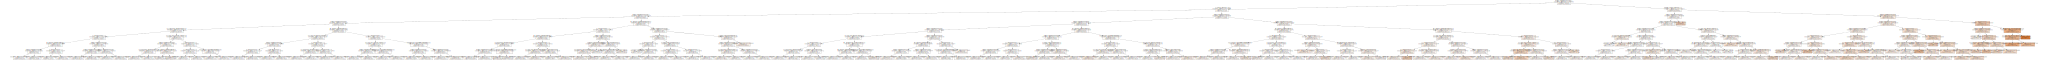

In [ ]:
# Criando a representação gráfica da árvore de decisão treinada
# Utilizando a função export_graphviz da biblioteca scikit-learn
data = tree.export_graphviz(regr1, out_file=None,
                                feature_names=X_train_c.columns,
                                filled=True)

# Criando um objeto Source do Graphviz para visualizar a árvore
graph = graphviz.Source(data, format="png")

# Visualizando a árvore de decisão
graph

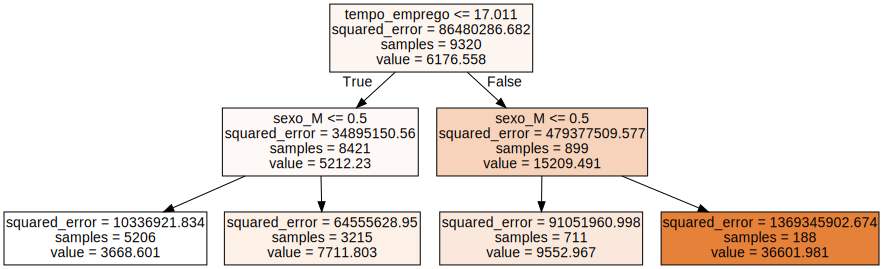

In [ ]:
# Criando a representação gráfica da árvore de decisão treinada
data = tree.export_graphviz(regr2, out_file=None,
                                feature_names=X_train_c.columns,
                                filled=True)

# Criando um objeto Source do Graphviz para visualizar a árvore
graph = graphviz.Source(data, format="png")

# Visualizando a árvore de decisão
graph

In [ ]:
# Calcula o caminho para a poda de complexidade de custo
path = regr1.cost_complexity_pruning_path(X_train_c, y_train_a)

Text(0, 0.5, 'Impureza total das folhas')

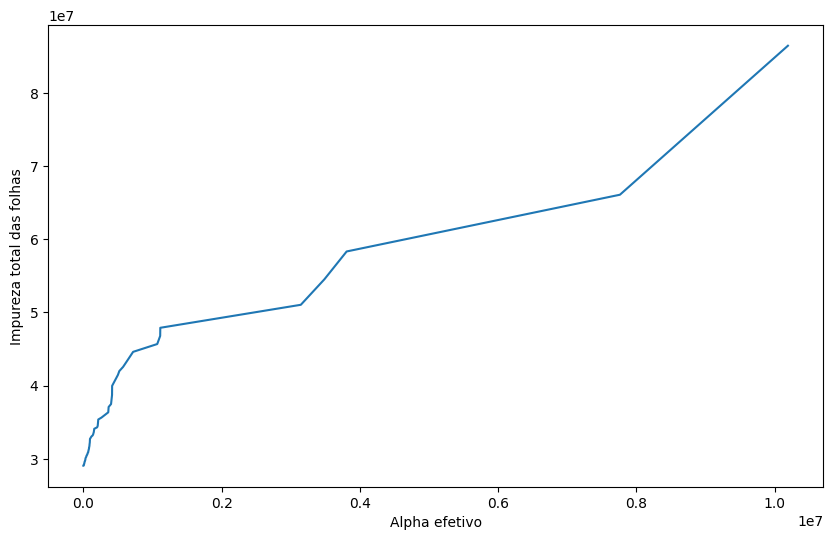

In [ ]:
# Obtendo os valores de ccp_alphas (parâmetros de complexidade) e impurities (impurezas) do caminho de custo-complexidade (path)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Criando uma figura com o tamanho de 10x6 polegadas para plotagem
plt.figure(figsize=(10, 6))

# Plotando o gráfico de ccp_alphas (parâmetros de complexidade) versus impurities (impurezas)
plt.plot(ccp_alphas, impurities)

# Definindo rótulos para os eixos x e y
plt.xlabel("Alpha efetivo")  # Rótulo do eixo x (alpha efetivo)
plt.ylabel("Impureza total das folhas")  # Rótulo do eixo y (impureza total das folhas)


In [ ]:
# Inicializando uma lista vazia para armazenar os modelos de árvore de decisão
clfs = []

# Iterando sobre os diferentes valores de ccp_alpha
for ccp_alpha in ccp_alphas:
    # Criando um modelo de árvore de decisão com o ccp_alpha atual
    # O ccp_alpha é um hiperparâmetro que controla a poda da árvore
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)

    # Treinando o modelo com os dados de treinamento
    clf.fit(X_train_c, y_train_a)

    # Adicionando o modelo treinado à lista de modelos
    clfs.append(clf)


Text(0, 0.5, 'Profundidade da árvore')

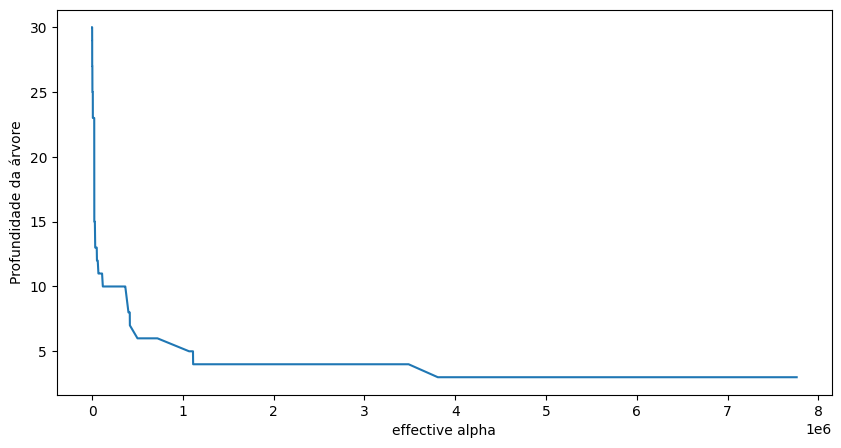

In [ ]:
# Criando a tree_depths
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  5))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Profundidade da árvore")

In [ ]:
# Calculando os scores de treinamento para cada classificador e armazenando-os em uma lista
train_scores = [mean_squared_error(y_train_a, clf.predict(X_train_c)) for clf in clfs]

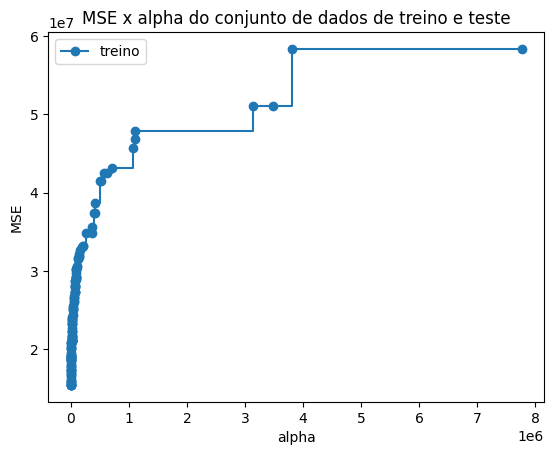

In [ ]:
# Visualizando o gráfico MSE x alpha
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="treino",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
# Criando o regressor de árvore de decisão com configurações específicas
arvore_final = DecisionTreeRegressor (random_state=0, ccp_alpha=.5)

# Treinando o modelo com os dados de treinamento
arvore_final.fit(X_train_c, y_train_a)

# Imprimindo a profundidade máxima da árvore treinada
print(f'Profundidade: {arvore_final.tree_.max_depth}')

# Calculando e imprimindo o erro médio quadrático nos dados de treinamento
print(f'MSE na base de testes: {mean_squared_error(y_train_a , arvore_final.predict(X_train_c)):.2f}')

Profundidade: 30
MSE na base de testes: 15464082.84


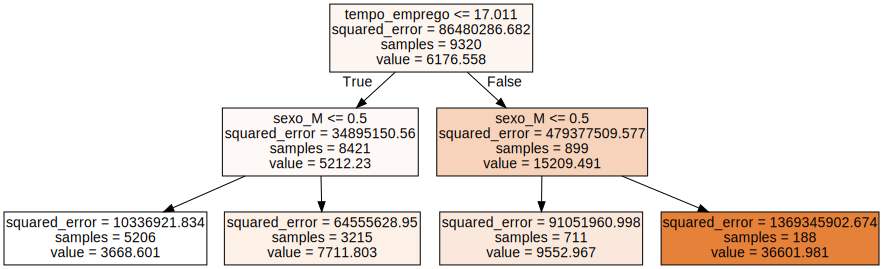

In [ ]:
ata = tree.export_graphviz(regr1, out_file=None,
                                feature_names=X_train_c.columns,
                                filled=True)

graph = graphviz.Source(data, format="png")
graph